# Benchmark 

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
proj_name = "dkd_Wilson"
file_name = "dkd_Wilson"
file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [5]:
# load the data
adata = sc.read_h5ad(data_dir / f"{file_name}.h5ad")

In [6]:
batch_key = 'donor_id'
state_key = 'cell_type'

# preprocess the data
# HVG selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key)

# Make sure counts are stored
if adata.raw is not None:
    raw_X = adata.raw[:, adata.var_names].X
    dense_X = raw_X.toarray() if sparse.issparse(raw_X) else raw_X

    if np.allclose(dense_X, np.round(dense_X)):
        adata.layers["counts"] = raw_X.astype(np.int32)
        print("✅ counts layer set from adata.raw (converted to int32)")
    else:
        raise ValueError("❌ adata.raw.X contains non-integer-like values.")
else:
    raise ValueError("❌ adata.raw is None — cannot set counts layer.")

# Subset to HVGs
adata = adata[:, adata.var.highly_variable].copy()

# Remove cells not expressing any HVG genes
adata = adata[adata.layers["counts"].sum(axis=1) > 0, :]

# PCA
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

# save the preprocessed data for job submission
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")


✅ counts layer set from adata.raw (converted to int32)


In [7]:
# create jobs for integration methods

proj_name = proj_name
adata_filename = 'dkd_Wilson_preprocessed.h5ad'
methods = 'concord scvi harmony scanorama liger unintegrated'
batch_key = batch_key
state_key = state_key
output_dir = '../jobs'
device = 'auto'
conda_env = 'scenv'
# mem = '16G'; scratch = '100G'; runtime = '02:00:00'; 

!python generate_py_sh_jobs.py \
  --proj_name {proj_name} \
  --adata_filename {adata_filename} \
  --methods {methods} \
  --batch_key {batch_key} \
  --state_key {state_key} \
  --output_dir {output_dir} \
  --device {device}

✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_concord.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_concord.sh

✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_scvi.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_scvi.sh

✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_harmony.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_harmony.sh

✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_scanorama.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_scanorama.sh

✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_liger.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_liger.sh

✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_unintegrated.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_unintegrated.sh



In [5]:
methods = 'scvi harmony scanorama liger unintegrated'

In [9]:
job_dir = Path(output_dir) / f"benchmark_{proj_name}"

method_list = methods.strip().split()

for method in method_list:
    sh_path = job_dir / f"benchmark_{proj_name}_{method}.sh"
    if sh_path.exists():
        print(f"✅ Submitting: {sh_path}")
        os.system(f"sh {sh_path}")
    else:
        print(f"⚠️  Skipped: {sh_path} not found")

✅ Submitting: ../jobs/benchmark_dkd_Wilson/benchmark_dkd_Wilson_scvi.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 16:44:04,623 - INFO - Using device: cuda
2025-06-17 16:44:04,724 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 16:44:04,735 - INFO - Logging to: ../../save/dkd_Wilson/scvi_0617-1643/run.log
2025-06-17 16:44:04,736 - INFO - Starting integration pipeline...
2025-06-17 16:44:07,417 - INFO - Loaded AnnData from: ../../data/dkd_Wilson/dkd_Wilson_preprocessed.h5ad
2025-06-17 16:44:23,761 - INFO - GPU available: True (cuda), used: True
2025-06-17 16:44:23,761 - INFO - TPU available: False, using: 0 TPU cores
2025-06-17 16:44:23,762 - INFO - HPU available: False, using: 0

✅ Submitting: ../jobs/benchmark_dkd_Wilson/benchmark_dkd_Wilson_harmony.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 16:56:46,258 - INFO - Using device: cuda
2025-06-17 16:56:46,329 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 16:56:46,340 - INFO - Logging to: ../../save/dkd_Wilson/harmony_0617-1656/run.log
2025-06-17 16:56:46,341 - INFO - Starting integration pipeline...
2025-06-17 16:56:48,967 - INFO - Loaded AnnData from: ../../data/dkd_Wilson/dkd_Wilson_preprocessed.h5ad
2025-06-17 16:56:51,837 - INFO - 	Initialization is completed.
2025-06-17 16:56:54,540 - INFO - 	Completed 1 / 10 iteration(s).
2025-06-17 16:56:57,638 - INFO - 	Completed 2 / 10 iteration(s).
2025-06-17 16

✅ Submitting: ../jobs/benchmark_dkd_Wilson/benchmark_dkd_Wilson_scanorama.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 16:57:14,885 - INFO - Using device: cuda
2025-06-17 16:57:14,959 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 16:57:14,966 - INFO - Logging to: ../../save/dkd_Wilson/scanorama_0617-1657/run.log
2025-06-17 16:57:14,968 - INFO - Starting integration pipeline...
2025-06-17 16:57:16,757 - INFO - Loaded AnnData from: ../../data/dkd_Wilson/dkd_Wilson_preprocessed.h5ad
2025-06-17 16:57:17,752 - INFO - Found 2000 genes among all datasets
2025-06-17 16:57:30,344 - INFO - [[0.         0.40527046 0.50651872 0.61849132 0.1993517  0.25658807
2025-06-17 16:57:30,346 - INFO -  

✅ Submitting: ../jobs/benchmark_dkd_Wilson/benchmark_dkd_Wilson_liger.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 16:59:36,228 - INFO - Using device: cuda
2025-06-17 16:59:36,356 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 16:59:36,364 - INFO - Logging to: ../../save/dkd_Wilson/liger_0617-1659/run.log
2025-06-17 16:59:36,387 - INFO - Starting integration pipeline...
2025-06-17 16:59:38,451 - INFO - Loaded AnnData from: ../../data/dkd_Wilson/dkd_Wilson_preprocessed.h5ad
2025-06-17 16:59:50,617 - INFO - /wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument t

✅ Submitting: ../jobs/benchmark_dkd_Wilson/benchmark_dkd_Wilson_unintegrated.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 17:06:13,971 - INFO - Using device: cuda
2025-06-17 17:06:14,042 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 17:06:14,051 - INFO - Logging to: ../../save/dkd_Wilson/unintegrated_0617-1706/run.log
2025-06-17 17:06:14,052 - INFO - Starting integration pipeline...
2025-06-17 17:06:16,667 - INFO - Loaded AnnData from: ../../data/dkd_Wilson/dkd_Wilson_preprocessed.h5ad
2025-06-17 17:06:16,669 - INFO - ✅ Selected methods completed.
2025-06-17 17:06:16,671 - INFO - Integration complete.
2025-06-17 17:06:17,989 - INFO - Saved embedding for 'unintegrated' to: ../../save/

In [ ]:
# adata = sc.read_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")

In [10]:
# map the obsm back to the adata 
# for each method, uses the most recent run (based on timestamp)
from benchmark_utils import add_embeddings

adata = add_embeddings(adata, proj_name=proj_name, methods=method_list)



✅ obsm['X_scvi'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP']
✅ obsm['scvi_UMAP'] computed
✅ obsm['X_harmony'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']
✅ obsm['harmony_UMAP'] computed
✅ obsm['X_scanorama'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP']
✅ obsm['scanorama_UMAP'] computed
✅ obsm['X_liger'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP']
✅ obsm['liger_UMAP'] computed
✅ obsm['X_unintegrated'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['unintegrated_UMAP']
✅ obsm['unintegrated_UMAP'] computed


In [16]:
# save the adata object
adata.write_h5ad(data_dir / f"{file_name}_final.h5ad")

In [17]:
adata

AnnData object with n_obs × n_vars = 39176 × 2000
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl', 'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches

In [13]:
# use scib-metrics to evaluate the embeddings
from benchmark_utils import run_scib_benchmark

embedding_keys = [f"X_{m}" for m in method_list]
bm = run_scib_benchmark(
    adata=adata,
    embedding_keys=embedding_keys, 
    batch_key=batch_key, # batch
    label_key=state_key, # label
    n_jobs=4
)

Embeddings: 100%|██████████| 5/5 [04:08<00:00, 49.73s/it]


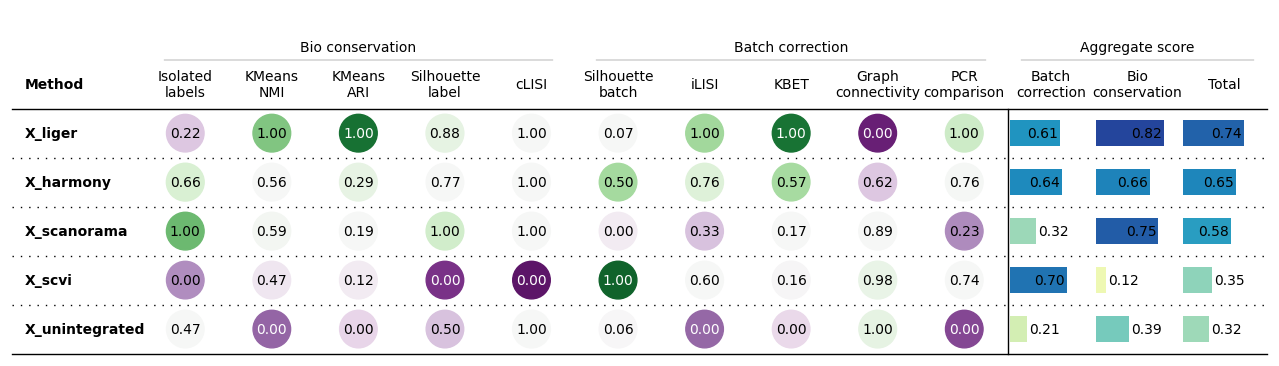

In [14]:
bm.plot_results_table()

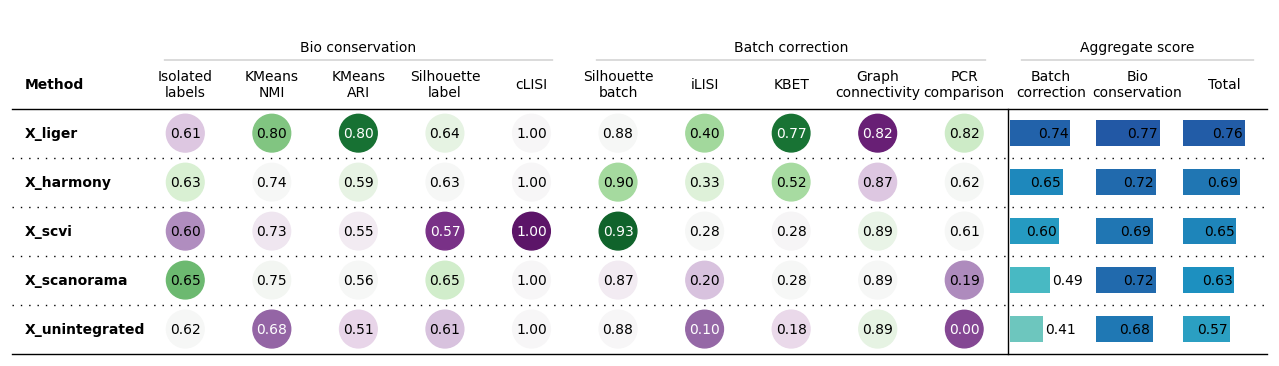

In [15]:
bm.plot_results_table(min_max_scale=False)

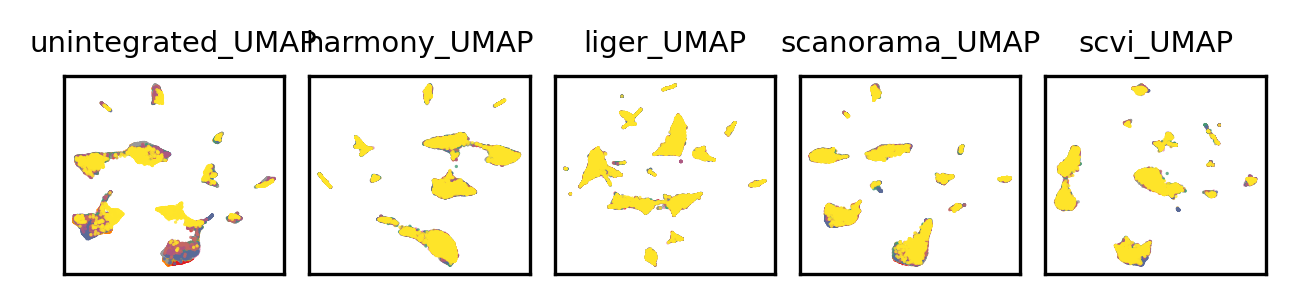

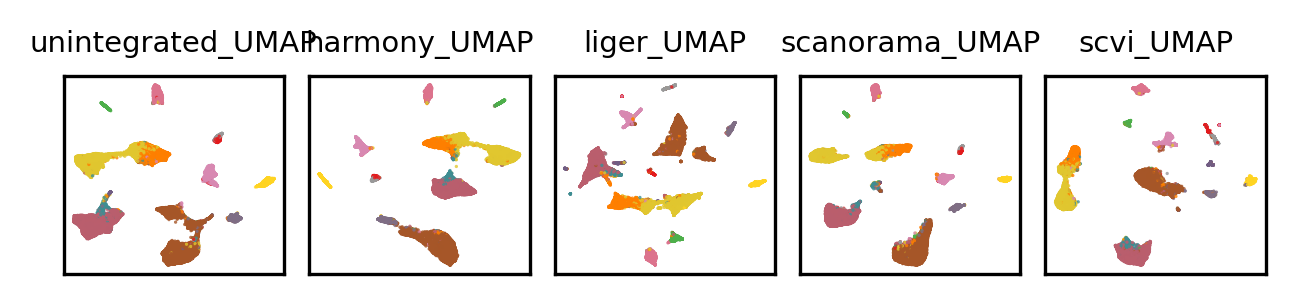

In [15]:
ccd.pl.plot_all_embeddings(
    adata=adata,
    combined_keys=['unintegrated_UMAP', 'harmony_UMAP', 'liger_UMAP', 'scanorama_UMAP', 'scvi_UMAP'],
    color_bys = [batch_key, state_key],  # e.g., batch_key is 'dataset', state_key is 'cell_type'
    basis_types=['UMAP'],
)

In [16]:
df = bm.get_results(min_max_scale=False)
print(df)

                 Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                              
X_scvi                  0.597763          0.734618          0.545114   
X_harmony               0.634404           0.74487          0.593591   
X_scanorama             0.653183          0.747912          0.563014   
X_liger                 0.610067          0.796534          0.799208   
X_unintegrated          0.623766          0.678835          0.509242   
Metric Type     Bio conservation  Bio conservation  Bio conservation   

                Silhouette label             cLISI  Silhouette batch  \
Embedding                                                              
X_scvi                  0.568436               1.0          0.925494   
X_harmony               0.627768               1.0          0.898868   
X_scanorama             0.645308               1.0           0.87255   
X_liger                 0.636466               1.0          0.8

# concord pipeline test

In [49]:
combined_keys = ['concord']

In [ ]:
time_log, ram_log, vram_log = ccd.ul.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    device=device,                 # Or "cpu", or "mps" for Apple Silicon
    # latent_dim=30,                        # Latent dimensionality for PCA and embeddings
    # return_corrected=False,                   # Whether to store corrected expression matrices
    # transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    # compute_umap=True,                    # Run UMAP for all output embeddings
    # umap_n_components=2,
    # umap_n_neighbors=30,
    # umap_min_dist=0.1,
    # seed=42,                              # Random seed for reproducibility
    verbose=True,                        # Print progress messages
)

In [ ]:
time_log, ram_log, vram_log = ccd.ul.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    device=device,                 # Or "cpu", or "mps" for Apple Silicon
    # latent_dim=30,                        # Latent dimensionality for PCA and embeddings
    # return_corrected=False,                   # Whether to store corrected expression matrices
    # transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    # compute_umap=True,                    # Run UMAP for all output embeddings
    # umap_n_components=2,
    # umap_n_neighbors=30,
    # umap_min_dist=0.1,
    # seed=42,                              # Random seed for reproducibility
    verbose=True,                        # Print progress messages
)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).


KeyboardInterrupt: 

In [ ]:
# save the adata object
adata.write_h5ad('../data/pbmc_Darmanis/pbmc_Darmanis_subset_9K.h5ad')